In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute

In [2]:
def find_equality(qc, pair_1, pair_2, result_qubit):
    
    qc.x(pair_1 + pair_2)
    qc.mct(pair_1 + pair_2, result_qubit)

    qc.x([pair_1[1], pair_2[1]])
    qc.mct(pair_1 + pair_2, result_qubit)
    
    qc.x(pair_1 + pair_2)
    qc.mct(pair_1 + pair_2, result_qubit)

    qc.x([pair_1[1], pair_2[1]])
    qc.mct(pair_1 + pair_2, result_qubit)

In [3]:
vertex_names = {
    'A': '00',
    'B': '01',
    'C': '10',
    'D': '11',
}

connections = {
    'A': ['C','D'],
    'B': ['C','D'],
    'C': ['A','B','D'],
    'D': ['A','B','C'],
}

vertex_to_11 = {
    'A': lambda qc, pair: qc.x(pair),
    'B': lambda qc, pair: qc.x(pair[0]),
    'C': lambda qc, pair: qc.x(pair[1]),
    'D': lambda qc, pair: None,
}

In [4]:
def find_disconnection(qc, pair_1, pair_2, ancilla_qubit, result_qubit):
    
    for letter_1 in connections.keys():
    
        vertex_to_find = [x for x in vertex_names.keys() if x not in connections[letter_1]]
        
        if len(vertex_to_find) > 0:

            vertex_to_11[letter_1](qc, pair_1)
            qc.toffoli(*pair_1, ancilla_qubit)
                        
            for letter_2 in vertex_to_find:
                vertex_to_11[letter_2](qc, pair_2)
                qc.mct([*pair_2, ancilla_qubit], result_qubit)
                vertex_to_11[letter_2](qc, pair_2)
            
            qc.toffoli(*pair_1, ancilla_qubit)
            vertex_to_11[letter_1](qc, pair_1)

In [5]:
def diffusion(qc, qubits):
    
    qc.x(qubits)
    qc.h(qubits[-1])
    
    length = len(qubits)
    
    if length > 3:
        qc.mct(qubits[0:-1], qubits[-1])
    elif length == 3:
        qc.toffoli(qubits[0:-1], qubits[2])
    elif length == 2:
        qc.cx(qubits[0], qubits[1])
    
    qc.h(qubits[-1])
    qc.x(qubits)

In [6]:
theta = 2 * np.arccos(1 / np.sqrt(3))

def exclude_00(qc, pair, reverse=False):
    
    if not reverse:
        qc.ry(theta, pair[0])
        qc.ch(pair[0], pair[1])
        qc.x(pair[1])
    else:
        qc.x(pair[1])
        qc.ch(pair[0], pair[1])
        qc.ry(-theta, pair[0])

In [7]:
qr = QuantumRegister(19)
cr = ClassicalRegister(8)
qc = QuantumCircuit(qr, cr)

exclude_00(qc, qr[0:2])
qc.h(qr[2:6])
exclude_00(qc, qr[6:8])

qc.x(17)
qc.h(17)

qc.barrier()

pairs = [
    [[qr[0],qr[1]], [qr[2],qr[3]]],
    [[qr[0],qr[1]], [qr[4],qr[5]]],
    [[qr[0],qr[1]], [qr[6],qr[7]]],
    [[qr[2],qr[3]], [qr[4],qr[5]]],
    [[qr[2],qr[3]], [qr[6],qr[7]]],
    [[qr[4],qr[5]], [qr[6],qr[7]]],
]

for i in range(2):
    
    # Oracle
        
    qc.x(qr[8:17])
    
    for i, pair in enumerate(pairs):    
        find_equality(qc, pair[0], pair[1], qr[8 + i])
    
    find_disconnection(qc, pair_1=qr[2:4], pair_2=qr[0:2], ancilla_qubit=qr[18], result_qubit=qr[14])
    find_disconnection(qc, pair_1=qr[4:6], pair_2=qr[2:4], ancilla_qubit=qr[18], result_qubit=qr[15])
    find_disconnection(qc, pair_1=qr[6:8], pair_2=qr[4:6], ancilla_qubit=qr[18], result_qubit=qr[16])
    
    # Store result
    
    qc.mct(qr[8:17], qr[17])
    
    # Oracle (reverse)
    
    find_disconnection(qc, pair_1=qr[6:8], pair_2=qr[4:6], ancilla_qubit=qr[18], result_qubit=qr[16])
    find_disconnection(qc, pair_1=qr[4:6], pair_2=qr[2:4], ancilla_qubit=qr[18], result_qubit=qr[15])
    find_disconnection(qc, pair_1=qr[2:4], pair_2=qr[0:2], ancilla_qubit=qr[18], result_qubit=qr[14])

    for i, pair in enumerate(pairs):    
        find_equality(qc, pair[0], pair[1], qr[8 + i])
    
    qc.x(qr[8:17])

    # Diffuser
    
    exclude_00(qc, qr[0:2], reverse=True)
    qc.h(qr[2:6])
    exclude_00(qc, qr[6:8], reverse=True)
    
    diffusion(qc, qr[0:8])
    
    exclude_00(qc, qr[0:2])
    qc.h(qr[2:6])
    exclude_00(qc, qr[6:8])

qc.measure(qr[0:8], cr)

In [8]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = simulator, shots = 1000).result()
counts = result.get_counts()
print(counts)

{'01101111': 1, '10111111': 2, '10011110': 1, '10111001': 1, '01010011': 2, '10101010': 2, '11111010': 1, '01111010': 2, '10100001': 1, '10100010': 2, '10000001': 3, '11010110': 2, '10001110': 2, '11000011': 1, '01110110': 3, '10110011': 2, '01111001': 4, '11101110': 3, '01011101': 3, '11101101': 4, '01111110': 4, '11000101': 2, '01010001': 2, '01101010': 3, '10110110': 2, '11110011': 3, '11110110': 3, '01000010': 4, '10011001': 6, '01001111': 4, '01110010': 3, '01001010': 4, '01011011': 6, '10100111': 2, '01000001': 1, '11010101': 4, '11011011': 2, '01011010': 7, '11011101': 5, '10001011': 6, '01100010': 3, '10101111': 3, '11011010': 6, '10001001': 4, '10000011': 3, '01001011': 4, '11110010': 2, '01011111': 1, '11000001': 2, '10000110': 8, '01110001': 3, '11010011': 2, '01100110': 1, '11001101': 7, '11111111': 5, '01101110': 4, '11100111': 7, '11000010': 1, '11001111': 4, '11001010': 5, '01001101': 1, '01010111': 1, '10010110': 3, '11010111': 4, '11111101': 3, '11101001': 3, '10001101

In [9]:
answers = {''.join(dict(zip(vertex_names.values(), vertex_names.keys()))[k[i*2:i*2+2]]
           for i in range(len(k)//2)): v
           for k, v in {item[0]: item[1]
           for item in sorted(counts.items(), key=lambda x:x[1], reverse=True)}.items()}
print(answers)

{'BADC': 154, 'CDAB': 134, 'DABC': 128, 'CBAD': 116, 'BDAD': 12, 'DDDC': 10, 'DCBB': 9, 'CABC': 8, 'BBCC': 7, 'DADB': 7, 'DCBD': 7, 'CAAC': 7, 'CCDB': 7, 'CCBC': 7, 'DCCC': 7, 'CBCB': 6, 'BBCD': 6, 'CACD': 6, 'DBCC': 6, 'CCDC': 6, 'CCAD': 6, 'DCAC': 6, 'CBBB': 6, 'DBDB': 5, 'DDDD': 5, 'DACC': 5, 'BCAB': 5, 'BBAC': 5, 'DBDC': 5, 'BBCB': 5, 'DCAD': 5, 'CABB': 5, 'BDCB': 4, 'DCDB': 4, 'BDDC': 4, 'BAAC': 4, 'BADD': 4, 'BACC': 4, 'DBBB': 4, 'CACB': 4, 'BACD': 4, 'BCDC': 4, 'DADD': 4, 'DBBD': 4, 'CDBB': 4, 'CBCC': 4, 'DCDD': 4, 'CBCD': 4, 'DBAC': 4, 'BDBD': 4, 'BBBC': 4, 'CBBD': 4, 'CDDB': 4, 'DCCD': 4, 'CDAC': 4, 'BDCD': 4, 'DCBC': 4, 'BDDD': 4, 'DACB': 4, 'BCBB': 4, 'CAAB': 3, 'BDBC': 3, 'DCDC': 3, 'BBDB': 3, 'BCCC': 3, 'DDAD': 3, 'DDBC': 3, 'BDAC': 3, 'BCAC': 3, 'CCDD': 3, 'CAAD': 3, 'BDAB': 3, 'CBBC': 3, 'DDDB': 3, 'DCCB': 3, 'CADB': 3, 'CCCD': 3, 'DDBD': 3, 'CDCD': 3, 'CDDC': 3, 'CBDD': 3, 'BDBB': 3, 'BABD': 3, 'CCBB': 3, 'BCAD': 3, 'BBBB': 3, 'BBDC': 3, 'CABD': 3, 'BABB': 3, 'CBAB': 3,

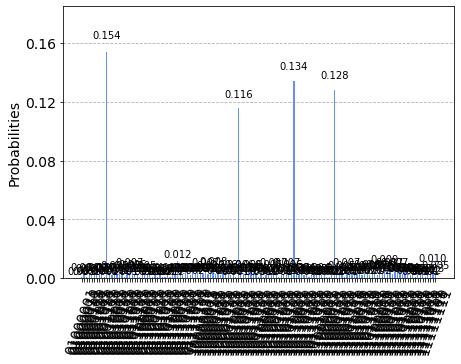

In [10]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)